# Multiple Testing and Variable Selection along Least Angle Regression's path

## Recursive formulation of LARS on HIV dataset

The scientific goal is to determine which mutations of the Human Immunodeficiency Virus Type 1 (HIV-1) are associated with drug resistance. The data set, publicly available from the [Stanford HIV Drug Resistance Database](https://hivdb.stanford.edu/pages/published_analysis/genophenoPNAS2006/), was originally analyzed in (Rhee et al. 2006). The analysis described here is based on the article "*Multiple Testing and Variable Selection along Least Angle Regression's path*" (Azaïs and De Castro, 2019). The dataset has been prepared as in "*Controlling the False Discovery Rate via Knockoffs*" (Barber and Candes, 2014). We present here the selected proatease positions that may present a resistance to APV.

In [1]:
import numpy as np

X = np.loadtxt('data/design.txt') #design of APV dataset
y = np.loadtxt('data/observation.txt') #response of APV dataset

n,p = np.shape(X)
print("There is p=%s observations for %s predictors." %(n,p))

There is p=767 observations for 201 predictors.


We compute the LAR's path using the recursive formulation of the article

In [2]:
from multiple_spacing_tests import lar_rec

print("Computing the recursive formulation of LAR as in (Azaïs and De Castro, 2019)")

lambdas, indexes, correls, R, Z = lar_rec(X, y, normalization = True) #Algorithm 1 in (Azaïs and De Castro, 2019)

Computing the recursive formulation of LAR as in (Azaïs and De Castro, 2019)


In [3]:
from sklearn import linear_model

print("Computing regularization path using the LAR from scikit learn.")

alphas, active, coefs = linear_model.lars_path(X, 
                                               y, 
                                               Xy           = Z[range(p)], 
                                               Gram         = R[0:p,0:p], 
                                               max_iter     = p-1, 
                                               method       = 'lar', 
                                               eps          = 1e-23,
                                               verbose      = False, 
                                               return_path  = True)

lambdas_lar_scikit_learn = n*alphas
indexes_lar_scikit_learn = active

Computing regularization path using the LAR from scikit learn.


We then compare the two algorithms on the HIV dataset. They offer the same output except on the tail of the LAR's path where sklearn gives abnormal values (the sequence is no longer non-increasing as it should be).

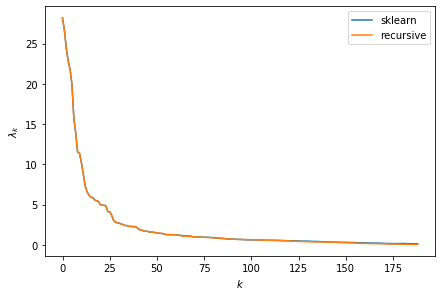

In [4]:
import matplotlib.pyplot as plt

k_max = min(np.size(indexes_lar_scikit_learn), np.size(indexes))

plt.plot(range(k_max-1),lambdas_lar_scikit_learn[:k_max-1])
plt.plot(range(k_max-1),lambdas[:k_max-1])
plt.legend([r'sklearn', r'recursive'])
plt.tight_layout()
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.show()

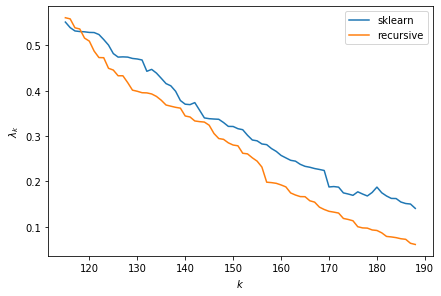

In [5]:
d = 75 #we focus on the last 75 values
plt.plot(range(k_max-d,k_max-1),lambdas_lar_scikit_learn[k_max-d:k_max-1])
plt.plot(range(k_max-d,k_max-1),lambdas[k_max-d:k_max-1])
plt.legend([r'sklearn', r'recursive'])
plt.tight_layout()
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.show()

In the above plot, SciKitLearn returns incresing values which is prohibited. The two algorithm retun the same values on the $50$ first knots of LAR.

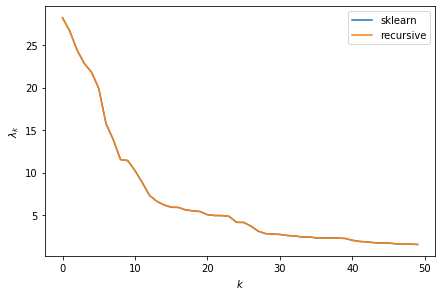

In [6]:
d = 50 #compare the 50 first knots
plt.plot(lambdas_lar_scikit_learn[0:d])
plt.plot(lambdas[0:d])
plt.legend([r'sklearn', r'recursive'])
plt.tight_layout()
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.show()

We can also compare the sequence of variables entering the model. Here again, they agree except on the tail of the LAR's path.

/Users/yohann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


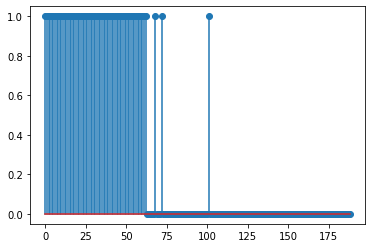

In [7]:
agree = 1*np.array(indexes[:k_max-1] == indexes_lar_scikit_learn[:k_max-1])
plt.stem(agree)
plt.show()

A deeper investigation shows that sklearn and the recuresive formulation differs at step $k=61$. Sklearn returns almost the same value $\lambda$ at step $k=61$ and $k=62$, and incoherent values (namely an increasing $\lambda$) at step $k=132$ (see below). We also computed the three others formualtions of the LAR (not showed here) and we found the same lambdas and indexes as in the recursive formulation presented here.

In [8]:
start = 61
end = 64
lambdas_lar_scikit_learn[start:end], lambdas[start:end], lambdas_lar_scikit_learn[132:134]

(array([1.21553574, 1.21498344, 1.17083938]),
 array([1.21553574, 1.18882636, 1.12469594]),
 array([0.44274209, 0.44699038]))

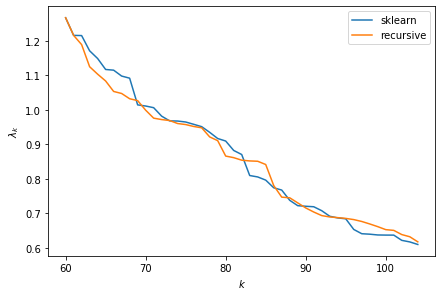

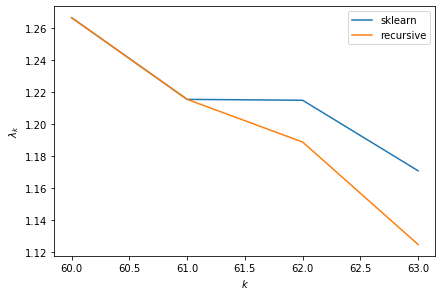

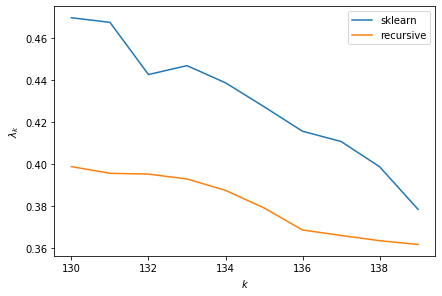

In [9]:
start = 60
end = 105
plt.plot(range(start,end),lambdas_lar_scikit_learn[start:end])
plt.plot(range(start, end),lambdas[start:end])
plt.legend([r'sklearn', r'recursive'])
plt.tight_layout()
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.show()

start = 60
end = 64
plt.plot(range(start,end),lambdas_lar_scikit_learn[start:end])
plt.plot(range(start, end),lambdas[start:end])
plt.legend([r'sklearn', r'recursive'])
plt.tight_layout()
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.show()

start = 130
end = 140
plt.plot(range(start,end),lambdas_lar_scikit_learn[start:end])
plt.plot(range(start, end),lambdas[start:end])
plt.legend([r'sklearn', r'recursive'])
plt.tight_layout()
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.show()

## Analysis of HIV dataset: Empirical Irrepresentability Check and Variance estimation

Of independent interest, we provide the order of "*Empirical Irrepresentability Check*" Check here. We found $K=26$.

In [10]:
from multiple_spacing_tests import get_order

order_irrep = get_order(Z,R)

print("The EIC holds with K=%s." %order_irrep)

The EIC holds with K=26.


We follow the heuristic described in the article (Azaïs and De Castro, 2019). 
1. We estimate the variance on the tail $(101,201)$ and assume that the residuals are centered on this tail (namely, the true support in included in $(1,101)$);
2. We will deploy Spacing Benjamini Hocheberg FDR control on the 26 first variables;
3. We will deploy False Negative control as presented in (Azaïs and De Castro, 2019).

We present 1. here. First, one has to get the residual at step $k=41$ and check the condition number of the covariance matrix (defined as the ratio between largest and least eigenvalue).

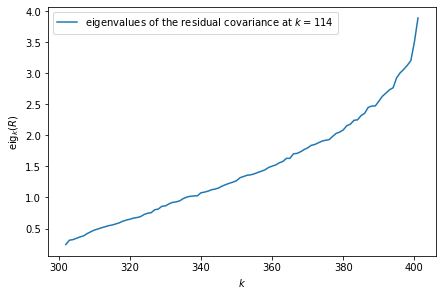

Condition number is 15.996150140061875.


In [11]:
from multiple_spacing_tests import get_residual

# We compute the residualt at step $k=41$
t=101
R1, Z1 = get_residual(R, Z, t)

# Take the spectral decomposition
w, v = np.linalg.eig(R1)
w = np.real(w)

# Compute the rank of the covariance matrix
rank = np.linalg.matrix_rank(R1)

# Plot its eigenvalues to witness its conditionning
vap = np.linalg.eigvalsh(R1)
plt.plot(range(2*p-rank,2*p),vap[2*p-rank:])
plt.legend([r'eigenvalues of the residual covariance at $k=114$'])
plt.tight_layout()
plt.xlabel(r'$k$')
plt.ylabel(r'$\mathrm{eig}_k(R)$')
plt.show()

condition_number = vap[-1]/vap[2*p-rank]

print("Condition number is %s." %condition_number)

The covariance matrix is well conditionned and we can estimate the variance by whitening the observation (as in linear model with homoscedastic noise). We check the centered Gaussian assumption by a distribution plot.

The standard deviation (noise level) is 0.4505563650833355.


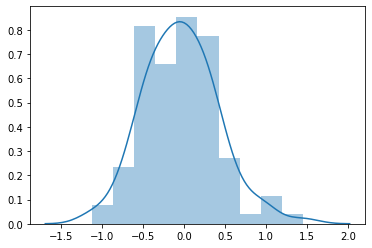

In [12]:
import seaborn as sns

# We take R2 = R1^(-1/2)
w2 = np.zeros(np.shape(w))
for k in range(np.size(w)):
    if abs(w[k])>1e-8:
        w2[k] = abs(w[k])**(-0.5)  
        R2 = np.real(np.dot(v,np.dot(np.diag(w2),np.transpose(v))))
        Z2 = np.dot(R2,Z1)

# We conpute the variance estimation
d = np.linalg.matrix_rank(R2, hermitian=True) # size of the projection space
V2 = v[:,0:d]
Y2 = np.real(np.dot(np.transpose(V2),Z2)) # projected Gaussian vector with covariance = sigma**2 times identity
var = (np.sum(Y2**2)-d*((np.sum(Y2)/d)**2))/(d-1) # unbiased estimator

# Plot of the "whitened" residuals
sns.distplot(Y2)

# standar deviation
sigma = np.sqrt(var)

print("The standard deviation (noise level) is %s." %sigma)

## Analysis of HIV dataset: Multiple Testing

We write $I_0$ fo the set 
$$
I_0=\big\{k\in[K]\ :\ \mathbb H_{0,k}\text{ is true}\big\}\,,
$$
Given a subset $\hat R\subseteq [K]$ of hypotheses that we consider as rejected, we call *false positive* ($\mathrm{FP}$) and *true positive* ($\mathrm{TP}$) the quantities $\mathrm{FP}=\mathrm{card}(\hat R\cap I_0)$ and $\mathrm{TP}=\mathrm{card}(\hat R\setminus I_0)$.

Denote by  $\hat p_{(1)}\leq\ldots\leq \hat p_{(K)}$ the $p$-values ranked in a nondecreasing order. Let $\alpha\in(0,1)$ and consider the Benjamini-Hochberg procedure defined by a rejection set $\hat R\subseteq[K]$ such that $\hat R=\emptyset$ when $\{k\in[K]\ :\ \hat p_{(k)}\leq\alpha k/K\}=\emptyset$ and 
$$
\hat R=\{k\in[K]\ :\ \hat p_k\leq \alpha\hat k/K\}\quad\mathrm{where}\quad \hat k=\max\big\{k\in[K]\ :\ \hat p_{(k)}\leq\alpha k/K\big\}\,.
$$

/Users/yohann/Dropbox/Yohann/0_Articles/Article_Joint_Law_Spacing_Test/Python/notebooks/multiple_spacing_tests.py:443: RuntimeWarning: invalid value encountered in double_scalars
  hat_alpha = num2 / den2


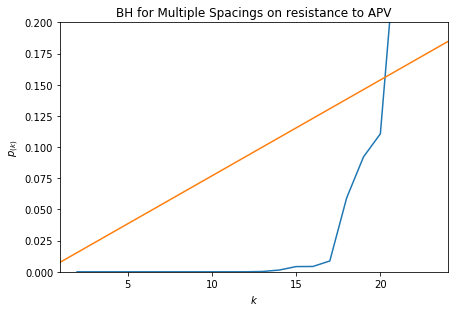

In [13]:
from multiple_spacing_tests import observed_significance_spacing

# Compute the LARS
lambdas, indexes, correls, R, Z = lar_rec(X, y, normalization = True)
lars = [lambdas, indexes, correls]

# Set the significance level and the number of testerd hypotheses 
alpha = 0.2
number_hyp = order_irrep

# Compute the observed significances
hat_alpha = np.zeros(number_hyp)
for start in range(number_hyp):
    hat_alpha[start] = observed_significance_spacing(lars, sigma, start)
    
# Order them to deploy Benjamini Hochberg procedure
p_ordered = sorted(hat_alpha, reverse=False)
x = np.cumsum(np.ones(number_hyp))

plt.plot(x, p_ordered)
plt.plot(x, alpha*x/number_hyp)
plt.tight_layout()
plt.xlabel(r'$k$')
plt.xlim([1,24])
plt.ylim([0,0.2])
plt.ylabel(r'$p_{(k)}$')
plt.title('BH for Multiple Spacings on resistance to APV')
plt.show()

# We found that 20 hyptohese are significant
k = 20

In [14]:
# The rejected hyptoheses are given by:
hat_alpha[np.isnan(hat_alpha)] = 0 
rejected = hat_alpha<=alpha*k/number_hyp

# whose indexes are: 
rej = 1*rejected
ind = indexes[:number_hyp]*rej
ind = ind[ind!=0]
ind = ind.astype(int)

# We extract the predictors names from the database
names = np.genfromtxt('data/predictors_names.txt', dtype=str)
rejected_names = names[ind]

print(rejected_names)

# FDR control -> 13 discoveries: 13 true and 0 false discoveries 
# Empirical Check Irrepresentability -> K = 26
# n = 767 and p = 201

['"P90.M"' '"P46.I"' '"P71.V"' '"P33.F"' '"P10.I"' '"P84.V"' '"P82.A"'
 '"P54.V"' '"P88.S"' '"P10.F"' '"P47.V"' '"P50.V"' '"P84.A"' '"P84.C"'
 '"P32.I"' '"P76.V"' '"P82.F"' '"P89.V"' '"P46.L"' '"P10.V"']


The next bar-plots have been obtained from the code *FDR_control.py* computing the FDR procedure of the paper (Azaïs and De Castro, 2019) on different drugs. 

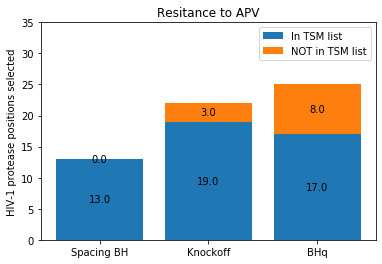

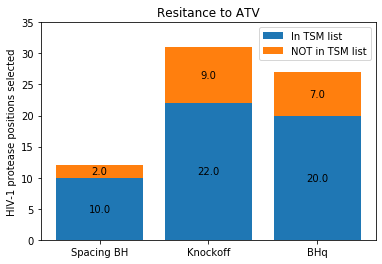

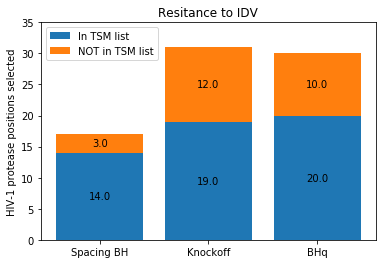

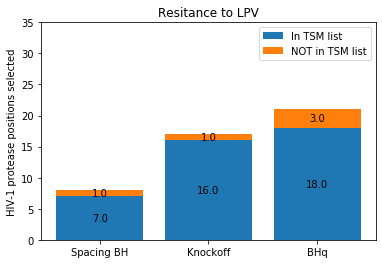

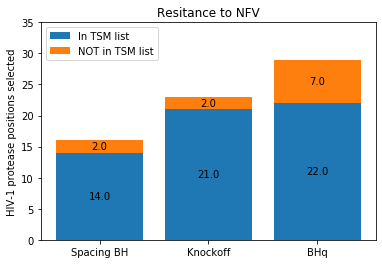

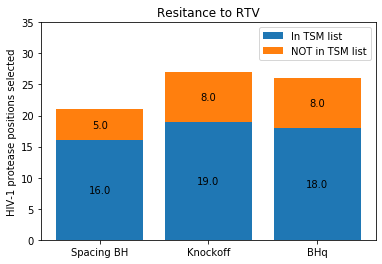

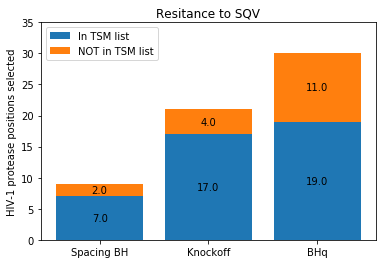

In [15]:
from multiple_spacing_tests import stacked_bar

# Results from Knockoff and BHq
comparisons = np.genfromtxt('data/comparisons.txt', delimiter=",", dtype=str)

#APV
plt.figure(figsize=(6, 4))
category_labels = ['Spacing BH', 'Knockoff', 'BHq']
series_labels = ['In TSM list', 'NOT in TSM list']

data = [[13, 19, 17],[0, 3, 8]]

stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    y_label="HIV-1 protease positions selected",
    grid=False
)

plt.ylim([0,35])
plt.title('Resitance to APV')
plt.savefig('data/barAPV.png')
plt.show()

# ATV
data = [[10, 22, 20],[2, 9, 7]]

stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    y_label="HIV-1 protease positions selected",
    grid=False
)

plt.ylim([0,35])
plt.title('Resitance to ATV')
plt.savefig('data/barATV.png')
plt.show()

# IDV
data = [[14, 19, 20],[3, 12, 10]]

stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    y_label="HIV-1 protease positions selected",
    grid=False
)

plt.ylim([0,35])
plt.title('Resitance to IDV')
plt.savefig('data/barIDV.png')
plt.show()

# LPV
data = [[7, 16, 18],[1, 1, 3]]

stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    y_label="HIV-1 protease positions selected",
    grid=False
)

plt.ylim([0,35])
plt.title('Resitance to LPV')
plt.savefig('data/barLPV.png')
plt.show()

# NFV
data = [[14, 21, 22],[2, 2, 7]]

stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    y_label="HIV-1 protease positions selected",
    grid=False
)

plt.ylim([0,35])
plt.title('Resitance to NFV')
plt.savefig('data/barNFV.png')
plt.show()

# RTV
data = [[16, 19, 18],[5, 8, 8]]

stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    y_label="HIV-1 protease positions selected",
    grid=False
)

plt.ylim([0,35])
plt.title('Resitance to RTV')
plt.savefig('data/barRTV.png')
plt.show()

# SQV
data = [[7, 17, 19],[2, 4, 11]]

stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    y_label="HIV-1 protease positions selected",
    grid=False
)

plt.ylim([0,35])
plt.title('Resitance to SQV')
plt.savefig('data/barSQV.png')
plt.show()


## Analysis of HIV dataset: False Negative Control

We deploy our exact false negative testing procedure on the dataset of HIV resistance to RTV drug. The *admissible* procedure is described by $(1)$ and $(2)$:

1. Fix $\alpha=0.2$;
2. Stop the first time $\hat m$ you observe three consecutive accepts using the spacing test (testing adnomarly large values of $\lambda_{a}$ conditional on $(\lambda_{a-1},\lambda_{a+1})$;
3. Test the significance of $\lambda_{\hat m+1}$ conditional on $(\lambda_{\hat m},\lambda_{K_{irr}})$, where $K_{irr}=36$ is the irrepresentability check order here. 

We start by estimating the variance on the tail $(101,205)$.

In [16]:
X = np.loadtxt('data/X_RTV.txt')
y = np.loadtxt('data/Y_RTV.txt')
n,p = np.shape(X)

#Compute LAR using recursive formulation
lambdas, indexes, correls, R, Z = lar_rec(X, y, normalization = True) 
lars = [lambdas, indexes, correls]
order_irrep = get_order(Z,R)

#estimate the variance on $(101,205)
t=101 

R1, Z1 = get_residual(R, Z, t)
w, v = np.linalg.eig(R1)
w = np.real(w)

w2 = np.zeros(np.shape(w))# We take R2 = R1^(-1/2)
for k in range(np.size(w)):
    if abs(w[k])>1e-8:
        w2[k] = abs(w[k])**(-0.5)  
        R2 = np.real(np.dot(v,np.dot(np.diag(w2),np.transpose(v))))
        Z2 = np.dot(R2,Z1)

# We conpute the variance estimation
d = np.linalg.matrix_rank(R2, hermitian=True)
V2 = v[:,0:d]
Y2 = np.real(np.dot(np.transpose(V2),Z2))
var = (np.sum(Y2**2)-d*((np.sum(Y2)/d)**2))/(d-1)

sigma = np.sqrt(var)

We then plot the sequence of $p$-values obtained by the spacing tests giving the significance of abnomarly large $\lambda_{a}$ conditional on $(\lambda_{a-1},\lambda_{a+1})$.

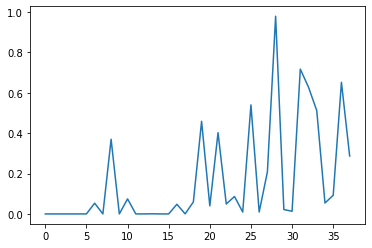

In [17]:
number_hyp = order_irrep

hat_alpha = np.zeros(number_hyp)
for start in range(number_hyp):
    hat_alpha[start] = observed_significance_spacing(lars, sigma, start)

hat_alpha[np.isnan(hat_alpha)] = 0 #very small values returns NAN (due a division) and need to be set to 0.
p_ordered = sorted(hat_alpha, reverse=False)

plt.plot(hat_alpha)

['"P48.V"' '"P89.M"' '"P64.V"' '"P10.I"' '"P82.A"' '"P46.I"' '"P39.P"'
 '"P76.V"' '"P36.I"' '"P33.F"' '"P14.R"' '"P24.I"' '"P73.T"' '"P84.A"'
 '"P46.L"' '"P82.F"' '"P84.C"' '"P46.V"' '"P36.V"' '"P47.V"' '"P32.I"'
 '"P38.L"' '"P39.S"' '"P50.L"' '"P43.T"' '"P10.F"' '"P58.E"' '"P79.S"'
 '"P72.X"' '"P54.A"' '"P19.T"' '"P67.S"' '"P19.Q"' '"P20.I"']


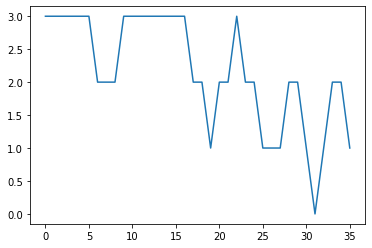

In [18]:
# We are looking for the first time we observe three consecutive accepts at level 0.2
alpha = 0.2
delta = 3

reject = 1*(hat_alpha<alpha)
test = reject[:-2]+reject[1:-1]+reject[2:]
plt.plot(test)

# We found:
hat_m = 34 

ind = indexes[:hat_m]
ind = ind.astype(int)
names = np.genfromtxt('data/predictors_names_nfv.txt', dtype=str)
positions_detected = names[ind]

# We print the corresponding locations and mutations
print(positions_detected)

In [19]:
from multiple_spacing_tests import observed_significance_CBC

# Compute the Multiple Spacing test 
p_value = observed_significance_CBC(lars,
                                    sigma,
                                    start=hat_m-1, 
                                    end=order_irrep, 
                                    middle=hat_m,
                                    eval_points=9973, #99991 is longer (in time) but better (in precision)
                                    rep=10)

print(p_value[0])

0.02949303985471613


The significance is $0.031$ and one may rejet that there is no false negative. Acutally, the positions detected contained $22$ true positive positions and $12$ true negatives are present (if one follows TSM database as ground truth). 